The idea is to prepare initial model, train it to recognize masked part of an image and further use to main problem (classification task). It is own pre-trained model and is called self-supervised image inpainting or context prediction.

In [ ]:
import os
import collections
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image, ImageDraw
import torch
from torchvision import transforms, datasets
from torch import nn
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
functions = files.upload()

Saving helper_functions.py to helper_functions.py


In [ ]:
from helper_functions import count_files_in_drive, create_dataset
from helper_functions import count_init_transform_shape, print_random_image
from helper_functions import show_transformed_images
from helper_functions import train_step, test_step, train_and_test

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' #device agnostic code

In [ ]:
DRIVE_PATH = '/content/drive/MyDrive/Pianki'

In [ ]:
folder_file_count = {}
zoom = 40 #different microscope maginification
folder_file_count = count_files_in_drive(folder_file_count, zoom, DRIVE_PATH)

In [ ]:
folder_file_count = collections.OrderedDict(sorted(folder_file_count.items()))

In [ ]:
sum(folder_file_count.values())

749

## Creating dataset

In [ ]:
data = pd.read_excel('/content/drive/MyDrive/Pianki/Dataset.xlsx', sheet_name='Arkusz2')
data.drop('sample_index', axis=1, inplace=True)

In [ ]:
dataset = create_dataset('/content/drive/MyDrive/Pianki', data, '40%_tension') #it is commonly known that mechanical properties are related with microstructure, so here I've chosen 40%_tension BUT
# I've also tested SAG factor (resulting mechanical properties), pHRR and U600 (thermal properties)

In [ ]:
rand_img = print_random_image(dataset, return_rand_img=True)

Random image path: /content/drive/MyDrive/Pianki/AS11/AS11_100_2.jpg
Sample: AS11
Property(40%_tension): 7.73
Image height: 1040
Image width: 1280


# Self-supervised image inpainting

In [ ]:
test_img = Image.open(dataset['image_path'][5])

In [ ]:
def cut_img(image, left=0, top=0, right=1280, bottom=960):
  '''
  Cutting image. Takes input:
    * left = 'x' coordination
    * right = left + img width
    * top = 'y' coordination
    * bottom = top + height
  '''

  return image.crop((left, top, right, bottom))

In [ ]:
im_crop = cut_img(test_img)

In [ ]:
resized_height, resized_width = count_init_transform_shape(im_crop.height, im_crop.width)
resized_height, resized_width

(168, 224)

In [ ]:
def mask_img(image, mask_size=(2, 2), masked_places=1, seed=42, mask_return=False):

  '''
  Mask random part of image.
  '''

  height, width = image.size
  masked_image = image.copy()

  for place in range(masked_places):

    random.seed(seed)
    top = np.random.randint(0, height - mask_size[0])
    left = np.random.randint(0, width - mask_size[1])
    bottom = top + mask_size[0]
    right = left + mask_size[1]


    draw = ImageDraw.Draw(masked_image)
    draw.rectangle([left, top, right, bottom], fill=0)

  return masked_image

  if mask_return:
    return masked_image, (left, top, right, bottom)

In [ ]:
data_transform = transforms.Compose([
    transforms.Lambda(cut_img),
    transforms.Resize(size=(resized_height, resized_width)),
    transforms.ToTensor()
])

In [ ]:
data_mask_transform = transforms.Compose([
    transforms.Lambda(cut_img),
    transforms.Resize(size=(resized_height, resized_width)),
    transforms.Lambda(mask_img),
    transforms.ToTensor()
])

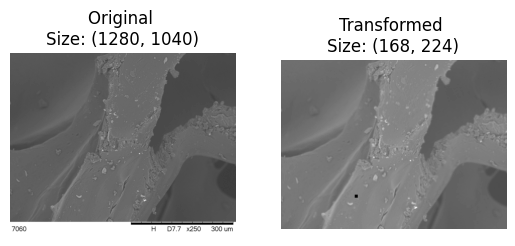

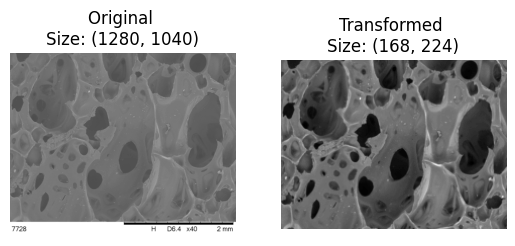

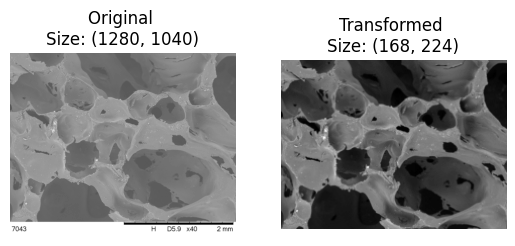

In [ ]:
show_transformed_images(list(dataset['image_path']), transform=data_mask_transform)

In [ ]:
loss_fn = nn.MSELoss()

# Create custom dataset with masked images and original ones.

In [ ]:
class CustomMaskedImageDataset(torch.utils.data.Dataset):
  def __init__(self, paths, transform=None, mask_transform=None):
    self.img_paths = paths
    self.transform = transform
    self.mask_transform = mask_transform

  def __len__(self):
    return len(self.img_paths)

  def __getitem__(self, idx):
    img_path = self.img_paths[idx]
    image = Image.open(img_path).convert('L')

    if self.transform:
      original_image = self.transform(image)
    else:
      original_image = transforms.ToTensor()(image)

    if self.mask_transform:
      masked_image = self.mask_transform(image)
    else:
      masked_image = transforms.ToTensor()(image)

    return masked_image, original_image


In [ ]:
data = CustomMaskedImageDataset(dataset['image_path'],
                                transform=data_transform,
                                mask_transform=data_mask_transform)

In [ ]:
dataloader = DataLoader(dataset=data,
                        batch_size=32,
                        num_workers=1,
                        shuffle=True)

In [ ]:
class ContextPredictor(nn.Module):
  def __init__(self, input_shape, hidden_units):
    super().__init__()

    #encoding layers

    self.conv_block_1 = nn.Sequential(
      nn.Conv2d(in_channels=input_shape,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
      nn.ReLU(),
      nn.Dropout(0.1),
      nn.MaxPool2d(kernel_size=2,
                      stride=2)
      )

    self.conv_block_2 = nn.Sequential(
      nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
      nn.ReLU(),
      nn.Dropout(0.1),
      nn.MaxPool2d(kernel_size=2,
                      stride=2)
      )

    self.encoder = nn.Sequential(
      self.conv_block_1,
      self.conv_block_2
      )

    #decoding layers

    self.deconv_block_1 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=hidden_units,
                          out_channels=hidden_units,
                          kernel_size=3,
                          stride=2,
                          padding=1,
                          output_padding=1), # Dodane output_padding
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels=hidden_units,
                          out_channels=hidden_units,
                          kernel_size=3,
                          stride=1,
                          padding=1),
        nn.ReLU(),
        nn.Dropout(0.1)
    )

    self.deconv_block_2 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=hidden_units,
                          out_channels=hidden_units,
                          kernel_size=3,
                          stride=2,
                          padding=1,
                          output_padding=1), # Dodane output_padding
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels=hidden_units,
                          out_channels=input_shape,
                          kernel_size=3, # Zmienione na 3
                          stride=1,
                          padding=1)
    )


    self.decoder = nn.Sequential(
      self.deconv_block_1,
      self.deconv_block_2
    )

  @staticmethod #static function, not instanction method
  def initialize_weights_xavier(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
      nn.init.xavier_uniform_(m.weight)
      if m.bias is not None: #if layer has a bias
        nn.init.zeros_(m.bias) #set bias to 0


  def forward(self, x):
    x = self.encoder(x)
    # print(x.shape)
    x = self.decoder(x)
    # print(x.shape)

    return x

In [ ]:
# import torch.nn as nn

# class ContextPredictor(nn.Module):
#     def __init__(self, input_shape=1, hidden_units=16):
#         super(ContextPredictor, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Conv2d(input_shape, hidden_units, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2)
#         )
#         self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(hidden_units, hidden_units, kernel_size=3, stride=2, padding=1, output_padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(hidden_units, input_shape, kernel_size=3, stride=1, padding=1)
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x


In [ ]:
loss_fn = nn.MSELoss()
n_splits=3
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
img_paths = list(dataset['image_path'])
cv_results = {}
split = 0 #param for saving results each corss-val step
actual_best_result = 1 #param for best model choosing

for train_index, test_index in kfold.split(img_paths): #cross-validation

  model = ContextPredictor(input_shape=1, #model initialization
                         hidden_units=16)
  model.apply(model.initialize_weights_xavier) #xavier weights initialization

  train_paths = [img_paths[i] for i in train_index]
  val_images = math.ceil(len(train_paths) * 0.15)
  val_paths = train_paths[-val_images:]
  train_paths = train_paths[:-val_images]
  test_paths = [img_paths[i] for i in test_index]
  split += 1

  train_data = CustomMaskedImageDataset(paths=train_paths, transform=data_transform, mask_transform=data_mask_transform)
  val_data = CustomMaskedImageDataset(paths=val_paths, transform=data_transform, mask_transform=data_mask_transform)
  test_data = CustomMaskedImageDataset(paths=test_paths, transform=data_transform, mask_transform=data_mask_transform)

  train_dataloader = DataLoader(dataset=train_data,
                        batch_size=32,
                        num_workers=1,
                        shuffle=True)
  val_dataloader = DataLoader(dataset=val_data,
                              batch_size=32,
                              num_workers=1,
                              shuffle=False)
  test_dataloader = DataLoader(dataset=test_data,
                               batch_size=32,
                               num_workers=1,
                               shuffle=False)
  # sample_inputs, _ = next(iter(train_dataloader))
  # print(sample_inputs.shape)

  train_loss_list, val_loss_list, epoch_counter = train_and_test(model=model,
                 train_dataloader=train_dataloader,
                 val_dataloader=val_dataloader,
                 test_dataloader=test_dataloader,
                 loss_fn=loss_fn,
                 optimizer='Adam',
                 device=device,
                 save_model_name='inpainting_model',
                 learning_rate=0.001,
                 epochs=80)
  cv_results[f' Train loss: {split}'] = train_loss_list
  cv_results[f' Test loss: {split}'] = val_loss_list

  #choose and save best model
  best_result = np.min(val_loss_list)
  if best_result < actual_best_result:
    actual_best_result = best_result
    torch.save(model.state_dict(), f'_inpainting_model_step_{split}_min_test_loss_{actual_best_result}')

  0%|          | 0/80 [00:00<?, ?it/s]

Train loss: 0.01516 | Learning rate: 0.0009000000000000001
Test loss: 0.00558


  1%|▏         | 1/80 [00:19<25:08, 19.10s/it]

Test loss: 0.00734
Train loss: 0.00825 | Learning rate: 0.0008100000000000001
Test loss: 0.00585


  2%|▎         | 2/80 [00:39<26:05, 20.07s/it]

Test loss: 0.00753
Train loss: 0.00790 | Learning rate: 0.000729
Test loss: 0.00563


  4%|▍         | 3/80 [00:59<25:14, 19.67s/it]

Test loss: 0.00691
Train loss: 0.00654 | Learning rate: 0.0006561000000000001
Test loss: 0.00354


  5%|▌         | 4/80 [01:18<24:57, 19.70s/it]

Test loss: 0.00466
Train loss: 0.00352 | Learning rate: 0.00059049
Test loss: 0.00183


  6%|▋         | 5/80 [01:39<24:56, 19.95s/it]

Test loss: 0.00222
Train loss: 0.00219 | Learning rate: 0.000531441
Test loss: 0.00149


  8%|▊         | 6/80 [01:58<24:19, 19.72s/it]

Test loss: 0.00196
Train loss: 0.00172 | Learning rate: 0.0004782969
Test loss: 0.00120


  9%|▉         | 7/80 [02:19<24:24, 20.07s/it]

Test loss: 0.00153
Train loss: 0.00158 | Learning rate: 0.00043046721
Test loss: 0.00108


 10%|█         | 8/80 [02:38<23:44, 19.79s/it]

Test loss: 0.00136
Train loss: 0.00135 | Learning rate: 0.000387420489
Test loss: 0.00103


 11%|█▏        | 9/80 [02:58<23:24, 19.78s/it]

Test loss: 0.00125
Train loss: 0.00130 | Learning rate: 0.0003486784401
Test loss: 0.00091


 12%|█▎        | 10/80 [03:17<22:55, 19.65s/it]

Test loss: 0.00112
Train loss: 0.00116 | Learning rate: 0.00031381059609000004
Test loss: 0.00078


 14%|█▍        | 11/80 [03:36<22:22, 19.46s/it]

Test loss: 0.00099
Train loss: 0.00096 | Learning rate: 0.00028242953648100003
Test loss: 0.00070


 15%|█▌        | 12/80 [03:56<22:21, 19.73s/it]

Test loss: 0.00089
Train loss: 0.00090 | Learning rate: 0.00025418658283290005
Test loss: 0.00066


 16%|█▋        | 13/80 [04:15<21:39, 19.40s/it]

Test loss: 0.00085
Train loss: 0.00088 | Learning rate: 0.00022876792454961005
Test loss: 0.00063


 18%|█▊        | 14/80 [04:35<21:27, 19.51s/it]

Test loss: 0.00080
Train loss: 0.00080 | Learning rate: 0.00020589113209464906
Test loss: 0.00059


 19%|█▉        | 15/80 [04:55<21:17, 19.65s/it]

Test loss: 0.00076
Train loss: 0.00078 | Learning rate: 0.00018530201888518417
Test loss: 0.00057


 20%|██        | 16/80 [05:14<20:49, 19.52s/it]

Test loss: 0.00074
Train loss: 0.00075 | Learning rate: 0.00016677181699666576
Test loss: 0.00056


 21%|██▏       | 17/80 [05:34<20:41, 19.71s/it]

Test loss: 0.00073
Train loss: 0.00074 | Learning rate: 0.0001500946352969992
Test loss: 0.00055


 22%|██▎       | 18/80 [05:53<20:03, 19.41s/it]

Test loss: 0.00070
Train loss: 0.00075 | Learning rate: 0.0001350851717672993
Test loss: 0.00054


 24%|██▍       | 19/80 [06:13<20:03, 19.72s/it]

Test loss: 0.00069
Train loss: 0.00071 | Learning rate: 0.00012157665459056936
Test loss: 0.00053


 25%|██▌       | 20/80 [06:33<19:36, 19.61s/it]

Test loss: 0.00068
Train loss: 0.00073 | Learning rate: 0.00010941898913151243
Test loss: 0.00052


 26%|██▋       | 21/80 [06:52<19:12, 19.54s/it]

Test loss: 0.00067
Train loss: 0.00070 | Learning rate: 9.847709021836118e-05
Test loss: 0.00051


 28%|██▊       | 22/80 [07:12<19:02, 19.71s/it]

Test loss: 0.00067
Train loss: 0.00067 | Learning rate: 8.862938119652506e-05
Test loss: 0.00051


 29%|██▉       | 23/80 [07:31<18:34, 19.55s/it]

Test loss: 0.00066
Train loss: 0.00067 | Learning rate: 7.976644307687256e-05
Test loss: 0.00050


 30%|███       | 24/80 [07:52<18:27, 19.78s/it]

Test loss: 0.00066
Train loss: 0.00067 | Learning rate: 7.17897987691853e-05
Test loss: 0.00050


 31%|███▏      | 25/80 [08:11<17:55, 19.55s/it]

Test loss: 0.00065
Train loss: 0.00066 | Learning rate: 6.461081889226677e-05
Test loss: 0.00050


 32%|███▎      | 26/80 [08:31<17:50, 19.82s/it]

Test loss: 0.00065
Train loss: 0.00064 | Learning rate: 5.81497370030401e-05
Test loss: 0.00049


 34%|███▍      | 27/80 [08:51<17:25, 19.73s/it]

Test loss: 0.00064
Train loss: 0.00068 | Learning rate: 5.233476330273609e-05
Test loss: 0.00049


 35%|███▌      | 28/80 [09:10<16:59, 19.60s/it]

Test loss: 0.00064
Train loss: 0.00068 | Learning rate: 4.7101286972462485e-05
Test loss: 0.00049


 36%|███▋      | 29/80 [09:31<17:00, 20.00s/it]

Test loss: 0.00064
Train loss: 0.00065 | Learning rate: 4.239115827521624e-05
Test loss: 0.00049


 38%|███▊      | 30/80 [09:51<16:39, 19.99s/it]

Test loss: 0.00063
Train loss: 0.00064 | Learning rate: 3.8152042447694614e-05
Test loss: 0.00049


 39%|███▉      | 31/80 [10:12<16:31, 20.24s/it]

Test loss: 0.00063
Train loss: 0.00065 | Learning rate: 3.433683820292515e-05
Test loss: 0.00048


 40%|████      | 32/80 [10:31<15:54, 19.88s/it]

Test loss: 0.00063
Train loss: 0.00065 | Learning rate: 3.090315438263264e-05
Test loss: 0.00048


 41%|████▏     | 33/80 [10:51<15:46, 20.14s/it]

Test loss: 0.00063
Train loss: 0.00066 | Learning rate: 2.7812838944369376e-05
Test loss: 0.00048


 42%|████▎     | 34/80 [11:10<15:07, 19.73s/it]

Test loss: 0.00063
Train loss: 0.00065 | Learning rate: 2.503155504993244e-05
Test loss: 0.00048


 44%|████▍     | 35/80 [11:30<14:42, 19.60s/it]

Test loss: 0.00063
Train loss: 0.00066 | Learning rate: 2.2528399544939195e-05
Test loss: 0.00048


 45%|████▌     | 36/80 [11:49<14:21, 19.59s/it]

Test loss: 0.00062
Train loss: 0.00065 | Learning rate: 2.0275559590445276e-05
Test loss: 0.00048


 46%|████▋     | 37/80 [12:08<13:48, 19.27s/it]

Test loss: 0.00062
Train loss: 0.00064 | Learning rate: 1.8248003631400748e-05
Test loss: 0.00048


 48%|████▊     | 38/80 [12:28<13:39, 19.51s/it]

Test loss: 0.00062
Train loss: 0.00063 | Learning rate: 1.6423203268260675e-05
Test loss: 0.00048


 49%|████▉     | 39/80 [12:47<13:17, 19.44s/it]

Test loss: 0.00062
Train loss: 0.00067 | Learning rate: 1.4780882941434607e-05
Test loss: 0.00047


 50%|█████     | 40/80 [13:06<12:47, 19.18s/it]

Test loss: 0.00062
Train loss: 0.00065 | Learning rate: 1.3302794647291146e-05
Test loss: 0.00047


 51%|█████▏    | 41/80 [13:25<12:36, 19.40s/it]

Test loss: 0.00062
Train loss: 0.00063 | Learning rate: 1.1972515182562031e-05
Test loss: 0.00047


 52%|█████▎    | 42/80 [13:44<12:04, 19.06s/it]

Test loss: 0.00062
Train loss: 0.00064 | Learning rate: 1.0775263664305828e-05
Test loss: 0.00047


 54%|█████▍    | 43/80 [14:03<11:43, 19.02s/it]

Test loss: 0.00062
Train loss: 0.00061 | Learning rate: 9.697737297875246e-06
Test loss: 0.00047


 55%|█████▌    | 44/80 [14:22<11:31, 19.22s/it]

Test loss: 0.00062
Train loss: 0.00064 | Learning rate: 8.727963568087722e-06
Test loss: 0.00047


 56%|█████▋    | 45/80 [14:41<11:05, 19.00s/it]

Test loss: 0.00062
Train loss: 0.00063 | Learning rate: 7.85516721127895e-06
Test loss: 0.00047


 57%|█████▊    | 46/80 [15:01<10:58, 19.36s/it]

Test loss: 0.00062
Train loss: 0.00064 | Learning rate: 7.069650490151056e-06
Test loss: 0.00047


 59%|█████▉    | 47/80 [15:19<10:28, 19.03s/it]

Test loss: 0.00062
Train loss: 0.00062 | Learning rate: 6.362685441135951e-06
Test loss: 0.00047


 60%|██████    | 48/80 [15:38<10:05, 18.92s/it]

Test loss: 0.00061
Train loss: 0.00063 | Learning rate: 5.7264168970223554e-06
Test loss: 0.00047


 61%|██████▏   | 49/80 [15:58<09:55, 19.21s/it]

Test loss: 0.00061
Train loss: 0.00062 | Learning rate: 5.15377520732012e-06
Test loss: 0.00047


 62%|██████▎   | 50/80 [16:16<09:27, 18.93s/it]

Test loss: 0.00061
Train loss: 0.00063 | Learning rate: 4.638397686588108e-06
Test loss: 0.00047


 64%|██████▍   | 51/80 [16:35<09:11, 19.02s/it]

Test loss: 0.00061
Train loss: 0.00064 | Learning rate: 4.174557917929298e-06
Test loss: 0.00047


 65%|██████▌   | 52/80 [16:55<08:55, 19.13s/it]

Test loss: 0.00061
Train loss: 0.00063 | Learning rate: 3.7571021261363684e-06
Test loss: 0.00047


 66%|██████▋   | 53/80 [17:13<08:31, 18.96s/it]

Test loss: 0.00061
Train loss: 0.00062 | Learning rate: 3.3813919135227317e-06
Test loss: 0.00047


 68%|██████▊   | 54/80 [17:33<08:20, 19.25s/it]

Test loss: 0.00061
Train loss: 0.00066 | Learning rate: 3.0432527221704586e-06
Test loss: 0.00047


 69%|██████▉   | 55/80 [17:52<07:58, 19.13s/it]

Test loss: 0.00061
Train loss: 0.00062 | Learning rate: 2.7389274499534128e-06
Test loss: 0.00047


 70%|███████   | 56/80 [18:11<07:34, 18.93s/it]

Test loss: 0.00061
Train loss: 0.00063 | Learning rate: 2.4650347049580716e-06
Test loss: 0.00047


 71%|███████▏  | 57/80 [18:31<07:23, 19.27s/it]

Test loss: 0.00061
Train loss: 0.00062 | Learning rate: 2.2185312344622644e-06
Test loss: 0.00047


 72%|███████▎  | 58/80 [18:49<07:00, 19.10s/it]

Test loss: 0.00061
Train loss: 0.00062 | Learning rate: 1.996678111016038e-06
Test loss: 0.00047


 74%|███████▍  | 59/80 [19:09<06:42, 19.15s/it]

Test loss: 0.00061
Train loss: 0.00061 | Learning rate: 1.7970102999144342e-06
Test loss: 0.00047


 75%|███████▌  | 60/80 [19:27<06:20, 19.01s/it]

Test loss: 0.00061
Train loss: 0.00065 | Learning rate: 1.6173092699229909e-06
Test loss: 0.00047


 76%|███████▋  | 61/80 [19:46<05:59, 18.92s/it]

Test loss: 0.00061
Train loss: 0.00063 | Learning rate: 1.4555783429306917e-06
Test loss: 0.00047


 78%|███████▊  | 62/80 [20:06<05:45, 19.19s/it]

Test loss: 0.00061
Train loss: 0.00062 | Learning rate: 1.3100205086376225e-06
Test loss: 0.00047


 79%|███████▉  | 63/80 [20:24<05:21, 18.88s/it]

Test loss: 0.00061
Train loss: 0.00065 | Learning rate: 1.1790184577738603e-06
Test loss: 0.00047


 80%|████████  | 64/80 [20:42<04:58, 18.63s/it]

Test loss: 0.00061
Train loss: 0.00062 | Learning rate: 1.0611166119964742e-06
Test loss: 0.00047


 81%|████████▏ | 65/80 [21:02<04:45, 19.01s/it]

Test loss: 0.00061
Train loss: 0.00062 | Learning rate: 9.550049507968269e-07
Test loss: 0.00047


 82%|████████▎ | 66/80 [21:20<04:23, 18.80s/it]

Test loss: 0.00061
Train loss: 0.00064 | Learning rate: 8.595044557171442e-07
Test loss: 0.00047


 84%|████████▍ | 67/80 [21:38<04:01, 18.60s/it]

Test loss: 0.00061
Train loss: 0.00062 | Learning rate: 7.735540101454298e-07
Test loss: 0.00047


 85%|████████▌ | 68/80 [21:58<03:47, 18.98s/it]

Test loss: 0.00061
Train loss: 0.00064 | Learning rate: 6.961986091308869e-07
Test loss: 0.00047


 86%|████████▋ | 69/80 [22:16<03:26, 18.78s/it]

Test loss: 0.00061
Train loss: 0.00064 | Learning rate: 6.265787482177982e-07
Test loss: 0.00047


 88%|████████▊ | 70/80 [22:39<03:18, 19.83s/it]

Test loss: 0.00061
Train loss: 0.00062 | Learning rate: 5.639208733960183e-07
Test loss: 0.00047


 89%|████████▉ | 71/80 [22:57<02:54, 19.38s/it]

Test loss: 0.00061
Train loss: 0.00065 | Learning rate: 5.075287860564165e-07
Test loss: 0.00047


 90%|█████████ | 72/80 [23:16<02:33, 19.23s/it]

Test loss: 0.00061
Train loss: 0.00063 | Learning rate: 4.567759074507748e-07
Test loss: 0.00047


 91%|█████████▏| 73/80 [23:35<02:15, 19.32s/it]

Test loss: 0.00061
Train loss: 0.00065 | Learning rate: 4.1109831670569735e-07
Test loss: 0.00047


 92%|█████████▎| 74/80 [23:54<01:53, 18.95s/it]

Test loss: 0.00061
Train loss: 0.00062 | Learning rate: 3.699884850351276e-07
Test loss: 0.00047


 94%|█████████▍| 75/80 [24:12<01:34, 18.83s/it]

Test loss: 0.00061
Train loss: 0.00063 | Learning rate: 3.329896365316149e-07
Test loss: 0.00047


 94%|█████████▍| 75/80 [24:32<01:38, 19.63s/it]


Test loss: 0.00061
Early stopping!


  0%|          | 0/80 [00:00<?, ?it/s]

Train loss: 0.13836 | Learning rate: 0.0009000000000000001
Test loss: 0.00938


  1%|▏         | 1/80 [00:18<24:13, 18.40s/it]

Test loss: 0.01066
Train loss: 0.01022 | Learning rate: 0.0008100000000000001
Test loss: 0.00544


  2%|▎         | 2/80 [00:38<25:11, 19.37s/it]

Test loss: 0.00585
Train loss: 0.00499 | Learning rate: 0.000729
Test loss: 0.00336


  4%|▍         | 3/80 [00:56<24:06, 18.78s/it]

Test loss: 0.00430
Train loss: 0.00424 | Learning rate: 0.0006561000000000001
Test loss: 0.00291


  5%|▌         | 4/80 [01:14<23:24, 18.48s/it]

Test loss: 0.00371
Train loss: 0.00357 | Learning rate: 0.00059049
Test loss: 0.00261


  6%|▋         | 5/80 [01:34<23:35, 18.87s/it]

Test loss: 0.00311
Train loss: 0.00288 | Learning rate: 0.000531441
Test loss: 0.00207


  8%|▊         | 6/80 [01:52<22:54, 18.58s/it]

Test loss: 0.00249
Train loss: 0.00235 | Learning rate: 0.0004782969
Test loss: 0.00158


  9%|▉         | 7/80 [02:10<22:31, 18.52s/it]

Test loss: 0.00200
Train loss: 0.00207 | Learning rate: 0.00043046721
Test loss: 0.00137


 10%|█         | 8/80 [02:30<22:40, 18.90s/it]

Test loss: 0.00175
Train loss: 0.00180 | Learning rate: 0.000387420489
Test loss: 0.00125


 11%|█▏        | 9/80 [02:48<22:07, 18.70s/it]

Test loss: 0.00160
Train loss: 0.00169 | Learning rate: 0.0003486784401
Test loss: 0.00123


 12%|█▎        | 10/80 [03:06<21:40, 18.57s/it]

Test loss: 0.00155
Train loss: 0.00160 | Learning rate: 0.00031381059609000004
Test loss: 0.00112


 14%|█▍        | 11/80 [03:26<21:50, 18.99s/it]

Test loss: 0.00145
Train loss: 0.00160 | Learning rate: 0.00028242953648100003
Test loss: 0.00114


 15%|█▌        | 12/80 [03:45<21:22, 18.86s/it]

Test loss: 0.00143
Train loss: 0.00147 | Learning rate: 0.00025418658283290005
Test loss: 0.00106


 16%|█▋        | 13/80 [04:04<21:05, 18.89s/it]

Test loss: 0.00139
Train loss: 0.00148 | Learning rate: 0.00022876792454961005
Test loss: 0.00110


 18%|█▊        | 14/80 [04:23<20:44, 18.86s/it]

Test loss: 0.00138
Train loss: 0.00164 | Learning rate: 0.00020589113209464906
Test loss: 0.00123


 19%|█▉        | 15/80 [04:41<20:13, 18.66s/it]

Test loss: 0.00148
Train loss: 0.00153 | Learning rate: 0.00018530201888518417
Test loss: 0.00109


 19%|█▉        | 15/80 [05:00<21:41, 20.03s/it]


Test loss: 0.00137
Early stopping!


  0%|          | 0/80 [00:00<?, ?it/s]

Train loss: 0.02385 | Learning rate: 0.0009000000000000001
Test loss: 0.00538


  1%|▏         | 1/80 [00:18<24:23, 18.52s/it]

Test loss: 0.00794
Train loss: 0.00855 | Learning rate: 0.0008100000000000001
Test loss: 0.00591


  2%|▎         | 2/80 [00:36<23:48, 18.31s/it]

Test loss: 0.00808
Train loss: 0.00777 | Learning rate: 0.000729
Test loss: 0.00527


  4%|▍         | 3/80 [00:56<24:10, 18.84s/it]

Test loss: 0.00714
Train loss: 0.00680 | Learning rate: 0.0006561000000000001
Test loss: 0.00418


  5%|▌         | 4/80 [01:14<23:29, 18.55s/it]

Test loss: 0.00544
Train loss: 0.00445 | Learning rate: 0.00059049
Test loss: 0.00295


  6%|▋         | 5/80 [01:32<23:05, 18.47s/it]

Test loss: 0.00341
Train loss: 0.00255 | Learning rate: 0.000531441
Test loss: 0.00162


  8%|▊         | 6/80 [01:52<23:13, 18.83s/it]

Test loss: 0.00195
Train loss: 0.00194 | Learning rate: 0.0004782969
Test loss: 0.00132


  9%|▉         | 7/80 [02:10<22:34, 18.55s/it]

Test loss: 0.00162
Train loss: 0.00162 | Learning rate: 0.00043046721
Test loss: 0.00134


 10%|█         | 8/80 [02:28<22:05, 18.41s/it]

Test loss: 0.00153
Train loss: 0.00140 | Learning rate: 0.000387420489
Test loss: 0.00099


 11%|█▏        | 9/80 [02:47<22:11, 18.75s/it]

Test loss: 0.00119
Train loss: 0.00120 | Learning rate: 0.0003486784401
Test loss: 0.00091


 12%|█▎        | 10/80 [03:05<21:35, 18.51s/it]

Test loss: 0.00109
Train loss: 0.00115 | Learning rate: 0.00031381059609000004
Test loss: 0.00084


 14%|█▍        | 11/80 [03:24<21:16, 18.50s/it]

Test loss: 0.00100
Train loss: 0.00103 | Learning rate: 0.00028242953648100003
Test loss: 0.00076


 15%|█▌        | 12/80 [03:43<21:22, 18.87s/it]

Test loss: 0.00092
Train loss: 0.00096 | Learning rate: 0.00025418658283290005
Test loss: 0.00073


 16%|█▋        | 13/80 [04:02<20:56, 18.76s/it]

Test loss: 0.00088
Train loss: 0.00090 | Learning rate: 0.00022876792454961005
Test loss: 0.00070


 18%|█▊        | 14/80 [04:21<20:43, 18.84s/it]

Test loss: 0.00083
Train loss: 0.00087 | Learning rate: 0.00020589113209464906
Test loss: 0.00066


 19%|█▉        | 15/80 [04:41<20:41, 19.11s/it]

Test loss: 0.00079
Train loss: 0.00085 | Learning rate: 0.00018530201888518417
Test loss: 0.00065


 20%|██        | 16/80 [04:59<20:07, 18.87s/it]

Test loss: 0.00077
Train loss: 0.00082 | Learning rate: 0.00016677181699666576
Test loss: 0.00062


 21%|██▏       | 17/80 [05:18<19:50, 18.90s/it]

Test loss: 0.00075
Train loss: 0.00082 | Learning rate: 0.0001500946352969992
Test loss: 0.00063


 22%|██▎       | 18/80 [05:36<19:25, 18.79s/it]

Test loss: 0.00075
Train loss: 0.00078 | Learning rate: 0.0001350851717672993
Test loss: 0.00061


 24%|██▍       | 19/80 [05:55<19:04, 18.76s/it]

Test loss: 0.00072
Train loss: 0.00079 | Learning rate: 0.00012157665459056936
Test loss: 0.00059


 25%|██▌       | 20/80 [06:15<19:10, 19.18s/it]

Test loss: 0.00070
Train loss: 0.00077 | Learning rate: 0.00010941898913151243
Test loss: 0.00058


 26%|██▋       | 21/80 [06:34<18:38, 18.95s/it]

Test loss: 0.00069
Train loss: 0.00073 | Learning rate: 9.847709021836118e-05
Test loss: 0.00057


 28%|██▊       | 22/80 [06:52<18:07, 18.76s/it]

Test loss: 0.00068
Train loss: 0.00072 | Learning rate: 8.862938119652506e-05
Test loss: 0.00056


 29%|██▉       | 23/80 [07:12<18:03, 19.01s/it]

Test loss: 0.00067
Train loss: 0.00072 | Learning rate: 7.976644307687256e-05
Test loss: 0.00055


 30%|███       | 24/80 [07:30<17:30, 18.76s/it]

Test loss: 0.00066
Train loss: 0.00072 | Learning rate: 7.17897987691853e-05
Test loss: 0.00055


 31%|███▏      | 25/80 [07:49<17:11, 18.76s/it]

Test loss: 0.00065
Train loss: 0.00070 | Learning rate: 6.461081889226677e-05
Test loss: 0.00054


 32%|███▎      | 26/80 [08:08<17:01, 18.92s/it]

Test loss: 0.00065
Train loss: 0.00070 | Learning rate: 5.81497370030401e-05
Test loss: 0.00054


 34%|███▍      | 27/80 [08:26<16:31, 18.71s/it]

Test loss: 0.00064
Train loss: 0.00069 | Learning rate: 5.233476330273609e-05
Test loss: 0.00053


 35%|███▌      | 28/80 [08:45<16:17, 18.80s/it]

Test loss: 0.00063
Train loss: 0.00069 | Learning rate: 4.7101286972462485e-05
Test loss: 0.00053


 36%|███▋      | 29/80 [09:04<16:08, 18.98s/it]

Test loss: 0.00063
Train loss: 0.00070 | Learning rate: 4.239115827521624e-05
Test loss: 0.00052


 38%|███▊      | 30/80 [09:23<15:45, 18.92s/it]

Test loss: 0.00062
Train loss: 0.00067 | Learning rate: 3.8152042447694614e-05
Test loss: 0.00052


 39%|███▉      | 31/80 [09:43<15:40, 19.19s/it]

Test loss: 0.00062
Train loss: 0.00067 | Learning rate: 3.433683820292515e-05
Test loss: 0.00051


 40%|████      | 32/80 [10:01<15:10, 18.97s/it]

Test loss: 0.00062
Train loss: 0.00067 | Learning rate: 3.090315438263264e-05
Test loss: 0.00051


 41%|████▏     | 33/80 [10:20<14:48, 18.90s/it]

Test loss: 0.00061
Train loss: 0.00065 | Learning rate: 2.7812838944369376e-05
Test loss: 0.00051


 42%|████▎     | 34/80 [10:40<14:40, 19.15s/it]

Test loss: 0.00061
Train loss: 0.00065 | Learning rate: 2.503155504993244e-05
Test loss: 0.00051


 44%|████▍     | 35/80 [10:58<14:11, 18.92s/it]

Test loss: 0.00061
Train loss: 0.00070 | Learning rate: 2.2528399544939195e-05
Test loss: 0.00050


 45%|████▌     | 36/80 [11:18<14:02, 19.14s/it]

Test loss: 0.00060
Train loss: 0.00065 | Learning rate: 2.0275559590445276e-05
Test loss: 0.00050


 46%|████▋     | 37/80 [11:37<13:34, 18.95s/it]

Test loss: 0.00060
Train loss: 0.00064 | Learning rate: 1.8248003631400748e-05
Test loss: 0.00050


 48%|████▊     | 38/80 [11:55<13:07, 18.74s/it]

Test loss: 0.00060
Train loss: 0.00065 | Learning rate: 1.6423203268260675e-05
Test loss: 0.00050


 49%|████▉     | 39/80 [12:15<13:02, 19.09s/it]

Test loss: 0.00059
Train loss: 0.00066 | Learning rate: 1.4780882941434607e-05
Test loss: 0.00049


 50%|█████     | 40/80 [12:33<12:33, 18.83s/it]

Test loss: 0.00059
Train loss: 0.00064 | Learning rate: 1.3302794647291146e-05
Test loss: 0.00049


 51%|█████▏    | 41/80 [12:51<12:05, 18.61s/it]

Test loss: 0.00059
Train loss: 0.00064 | Learning rate: 1.1972515182562031e-05
Test loss: 0.00049


 52%|█████▎    | 42/80 [13:11<12:01, 18.98s/it]

Test loss: 0.00059
Train loss: 0.00064 | Learning rate: 1.0775263664305828e-05
Test loss: 0.00049


 54%|█████▍    | 43/80 [13:29<11:35, 18.79s/it]

Test loss: 0.00059
Train loss: 0.00064 | Learning rate: 9.697737297875246e-06
Test loss: 0.00049


 55%|█████▌    | 44/80 [13:48<11:12, 18.68s/it]

Test loss: 0.00058
Train loss: 0.00064 | Learning rate: 8.727963568087722e-06
Test loss: 0.00049


 56%|█████▋    | 45/80 [14:07<11:04, 18.98s/it]

Test loss: 0.00058
Train loss: 0.00064 | Learning rate: 7.85516721127895e-06
Test loss: 0.00049


 57%|█████▊    | 46/80 [14:26<10:42, 18.89s/it]

Test loss: 0.00058
Train loss: 0.00066 | Learning rate: 7.069650490151056e-06
Test loss: 0.00048


 59%|█████▉    | 47/80 [14:46<10:36, 19.29s/it]

Test loss: 0.00058
Train loss: 0.00064 | Learning rate: 6.362685441135951e-06
Test loss: 0.00048


 60%|██████    | 48/80 [15:05<10:16, 19.26s/it]

Test loss: 0.00058
Train loss: 0.00063 | Learning rate: 5.7264168970223554e-06
Test loss: 0.00048


 61%|██████▏   | 49/80 [15:24<09:50, 19.04s/it]

Test loss: 0.00058
Train loss: 0.00064 | Learning rate: 5.15377520732012e-06
Test loss: 0.00048


 62%|██████▎   | 50/80 [15:43<09:34, 19.15s/it]

Test loss: 0.00058
Train loss: 0.00062 | Learning rate: 4.638397686588108e-06
Test loss: 0.00048


 64%|██████▍   | 51/80 [16:02<09:07, 18.89s/it]

Test loss: 0.00058
Train loss: 0.00062 | Learning rate: 4.174557917929298e-06
Test loss: 0.00048


 65%|██████▌   | 52/80 [16:20<08:44, 18.72s/it]

Test loss: 0.00058
Train loss: 0.00063 | Learning rate: 3.7571021261363684e-06
Test loss: 0.00048


 66%|██████▋   | 53/80 [16:39<08:29, 18.88s/it]

Test loss: 0.00058
Train loss: 0.00062 | Learning rate: 3.3813919135227317e-06
Test loss: 0.00048


 68%|██████▊   | 54/80 [16:57<08:04, 18.64s/it]

Test loss: 0.00058
Train loss: 0.00063 | Learning rate: 3.0432527221704586e-06
Test loss: 0.00048


 69%|██████▉   | 55/80 [17:16<07:50, 18.81s/it]

Test loss: 0.00058
Train loss: 0.00061 | Learning rate: 2.7389274499534128e-06
Test loss: 0.00048


 70%|███████   | 56/80 [17:36<07:34, 18.92s/it]

Test loss: 0.00057
Train loss: 0.00064 | Learning rate: 2.4650347049580716e-06
Test loss: 0.00048


 71%|███████▏  | 57/80 [17:54<07:09, 18.68s/it]

Test loss: 0.00057
Train loss: 0.00063 | Learning rate: 2.2185312344622644e-06
Test loss: 0.00048


 72%|███████▎  | 58/80 [18:13<06:54, 18.86s/it]

Test loss: 0.00057
Train loss: 0.00063 | Learning rate: 1.996678111016038e-06
Test loss: 0.00048


 74%|███████▍  | 59/80 [18:32<06:33, 18.75s/it]

Test loss: 0.00057
Train loss: 0.00064 | Learning rate: 1.7970102999144342e-06
Test loss: 0.00048


 75%|███████▌  | 60/80 [18:50<06:12, 18.61s/it]

Test loss: 0.00057
Train loss: 0.00063 | Learning rate: 1.6173092699229909e-06
Test loss: 0.00048


 76%|███████▋  | 61/80 [19:09<05:58, 18.89s/it]

Test loss: 0.00057
Train loss: 0.00062 | Learning rate: 1.4555783429306917e-06
Test loss: 0.00048


 78%|███████▊  | 62/80 [19:28<05:36, 18.71s/it]

Test loss: 0.00057
Train loss: 0.00062 | Learning rate: 1.3100205086376225e-06
Test loss: 0.00048


 79%|███████▉  | 63/80 [19:46<05:16, 18.64s/it]

Test loss: 0.00057
Train loss: 0.00064 | Learning rate: 1.1790184577738603e-06
Test loss: 0.00048


 80%|████████  | 64/80 [20:06<05:02, 18.92s/it]

Test loss: 0.00057
Train loss: 0.00062 | Learning rate: 1.0611166119964742e-06
Test loss: 0.00048


 81%|████████▏ | 65/80 [20:24<04:41, 18.78s/it]

Test loss: 0.00057
Train loss: 0.00062 | Learning rate: 9.550049507968269e-07
Test loss: 0.00048


 82%|████████▎ | 66/80 [20:42<04:20, 18.59s/it]

Test loss: 0.00057
Train loss: 0.00062 | Learning rate: 8.595044557171442e-07
Test loss: 0.00048


 84%|████████▍ | 67/80 [21:02<04:04, 18.82s/it]

Test loss: 0.00057
Train loss: 0.00062 | Learning rate: 7.735540101454298e-07
Test loss: 0.00048


 85%|████████▌ | 68/80 [21:20<03:43, 18.60s/it]

Test loss: 0.00057
Train loss: 0.00062 | Learning rate: 6.961986091308869e-07
Test loss: 0.00048


 86%|████████▋ | 69/80 [21:38<03:24, 18.63s/it]

Test loss: 0.00057
Train loss: 0.00062 | Learning rate: 6.265787482177982e-07
Test loss: 0.00048


 86%|████████▋ | 69/80 [21:57<03:30, 19.10s/it]

Test loss: 0.00057
Early stopping!


In [ ]:
sample, _ = next(iter(test_dataloader))

In [ ]:
model.eval()
with torch.no_grad():
  preds = model(sample.to(device))

In [ ]:
def show_predicted_mask(index: int = 0):
  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.imshow(sample[index].permute(1, 2, 0).numpy(), cmap='gray')
  plt.title('Original image')

  plt.subplot(1, 2, 2)
  plt.imshow(preds[index].squeeze().cpu().numpy(), cmap='gray')
  plt.title('Predicted mask')

  plt.show()

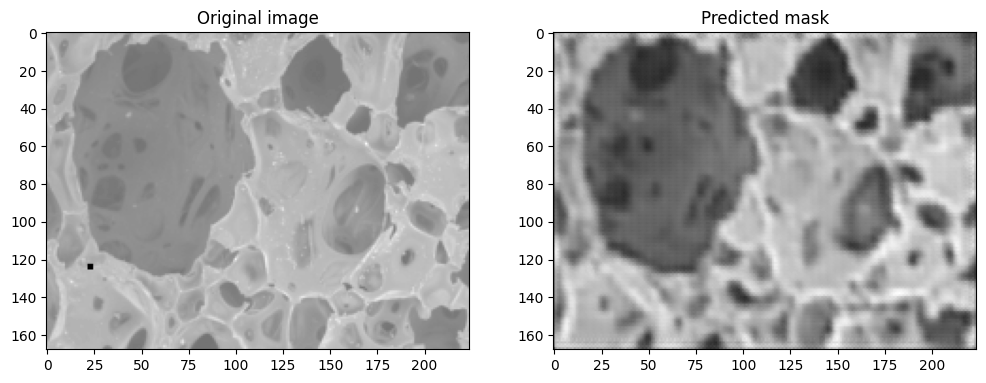

In [ ]:
show_predicted_mask(20)